# 교수 평점 예측하기

# 01. 데이터 소개 및 분석프로세스 수립

**대학생들의 수강 신청**은 새 학기가 시작되기 전 이루어집니다.

학생들은 보통 본인이 **필요로하는 강좌의 정보**와 **해당 강좌를 담당하는 교수의 대한 정보**를 종합해 의사결정을 내리는데요.

이번 프로젝트를 통해 학생들이 `리뷰 커뮤니티`와 `교수의 강의계획서`를 통해 해당 강좌의 `추천 여부`를 예측해 의사결정에 활용할 수 있도록

**수강 추천도**를 분류하는 모델을 만들어 보겠습니다.

> 리뷰 커뮤니티

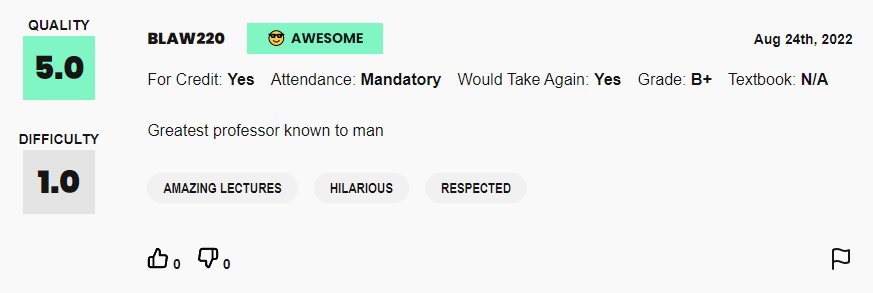

> 강의 계획서

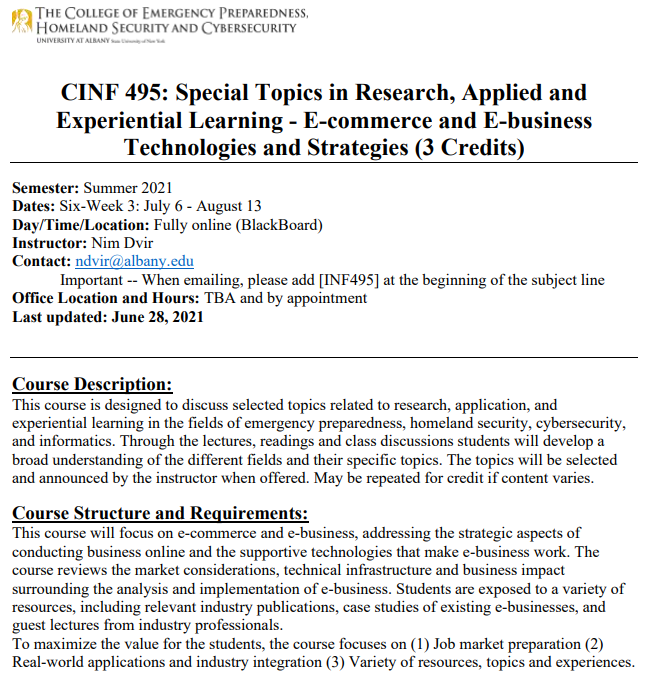

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [1]:
# # 한글 깨짐 현상 해결
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm
# from matplotlib import pyplot as plt

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [2]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np 
import pandas as pd 
import seaborn as sns

import re

from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
from itertools import combinations
from collections import Counter, defaultdict

from scipy.stats import pearsonr, chi2_contingency

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [4]:
df = pd.read_csv('/content/MyDrive/MyDrive/RateMyProfessor.csv')
df.head()

,professor_name,school_name,department_name,local_name,state_name,year_since_first_review,star_rating,take_again,diff_index,tag_professor,...,lots_of_homework,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline
0,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
1,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
2,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
3,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0
4,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,11.0,4.7,NaN,2.0,Hilarious (2) GROUP PROJECTS (2) Gives good ...,...,0,0,0,0,0,1,0,0,0,0


### 데이터 탐색 및 전처리

In [5]:
# 데이터 형태
df.shape

(20000, 51)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   professor_name            20000 non-null  object 
 1   school_name               20000 non-null  object 
 2   department_name           20000 non-null  object 
 3   local_name                20000 non-null  object 
 4   state_name                20000 non-null  object 
 5   year_since_first_review   20000 non-null  float64
 6   star_rating               20000 non-null  float64
 7   take_again                2998 non-null   object 
 8   diff_index                20000 non-null  float64
 9   tag_professor             11093 non-null  object 
 10  num_student               20000 non-null  float64
 11  post_date                 19995 non-null  object 
 12  name_onlines              20000 non-null  object 
 13  name_not_onlines          19995 non-null  object 
 14  studen

In [7]:
df['post_date'] = pd.to_datetime(df['post_date'], format='%m/%d/%Y')
df['post_date'].head()

0   2017-06-27
1   2017-04-16
2   2016-12-07
3   2014-12-08
4   2014-05-02
Name: post_date, dtype: datetime64[ns]

In [8]:
dtypes_data = df.dtypes.reset_index()
dtypes_data.columns = ['count', 'column type']
dtypes_data = dtypes_data.groupby('column type').aggregate('count').reset_index()
dtypes_data

,column type,count
0,float64,13
1,datetime64[ns],1
2,int64,21
3,object,16


#### 결측값

In [9]:
df.isnull().any().any()

True

In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count', ascending=False)
missing_df

,column_name,missing_count
18,would_take_agains,17418
7,take_again,17002
19,grades,16708
16,attence,15991
17,for_credits,15947
9,tag_professor,8907
22,comments,7
23,word_comment,7
11,post_date,5
13,name_not_onlines,5


In [11]:
def plot_missing_data(df):
  try:
    columns_with_null = df.columns[df.isnull().sum() > 0]
    null_pct = (df[columns_with_null].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(y = null_pct.index, x = null_pct, orient='h', palette='viridis')
    plt.title('데이터 내 Column 별 결측치 비율 (%)', fontsize=16)
  except:
    print('데이터 내 결측치가 없습니다.')

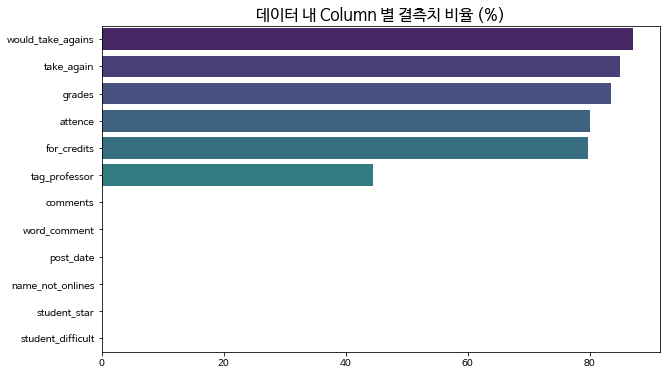

In [12]:
plot_missing_data(df)

#### 중복값

In [13]:
print('데이터 내 중복된 항목 수:', len(df[df.duplicated()]))

데이터 내 중복된 항목 수: 19


In [14]:
def plot_unique_data(df):
  columns_with_unique = df.columns[df.nunique() > 1]
  unique_pct = (df[columns_with_unique].nunique() / df.shape[0] *100).sort_values(ascending=False)[:10]
  plt.figure(figsize=(10, 6))
  sns.barplot(y = unique_pct.index, x = unique_pct, orient='h', palette='viridis')
  plt.title('데이터 내 Column 별 유니크 값 비율 (%)', fontsize=16)

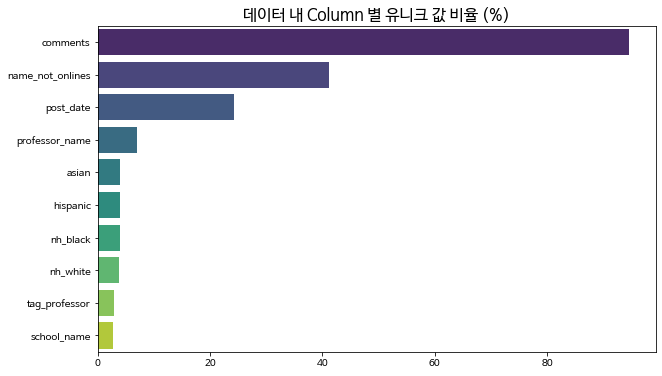

In [15]:
plot_unique_data(df)

In [16]:
df.shape

(20000, 51)

중복 값 제거

In [17]:
df = df.drop_duplicates(keep='first')
df.shape

(19981, 51)

#### 범주형 features

> 각 feature 별 unique한 값 개수

In [18]:
cat_feat = df.select_dtypes(include='object').columns
cat_feat

Index(['professor_name', 'school_name', 'department_name', 'local_name',
       'state_name', 'take_again', 'tag_professor', 'name_onlines',
       'name_not_onlines', 'attence', 'for_credits', 'would_take_agains',
       'grades', 'comments', 'gender', 'race'],
      dtype='object')

In [19]:
df[cat_feat].nunique().sort_values()

attence                  2
for_credits              2
would_take_agains        2
race                     3
gender                   6
grades                  18
take_again              43
state_name              57
department_name        101
name_onlines           235
local_name             417
school_name            554
tag_professor          591
professor_name        1413
name_not_onlines      8230
comments             18923
dtype: int64

##### Grades 

In [20]:
df['grades'].value_counts()

A           1052
A+           538
B            376
B+           339
A-           281
Not          173
B-           112
C            110
C+            96
WD            65
C-            39
F             31
D             26
INC           15
P             13
D+            12
D-             8
Audit/No       6
Name: grades, dtype: int64

In [21]:
def new_grades(x):
  if x == 'A+' or x == 'A' or x =='A-':
    return 'A'
  elif x == 'B+' or x == 'B' or x == 'B-':
    return 'B'
  elif x == 'C+' or x == 'C' or x == 'C-':
    return 'C'
  elif x == 'D+' or x == 'D' or x == 'D-':
    return 'D'
  elif x == 'F':
    return 'F'
  elif x == 'WD' or x == 'INC':
    return 'Drop/Withdrawal'
  elif x == 'P':
    return 'Pass'
  elif x == 'INC' or x == 'Not':
    return 'Not sure yet'
  else:
    return 'No grade'

In [22]:
df['grades'] = df['grades'].apply(new_grades)
df['grades'].value_counts()

No grade           16695
A                   1871
B                    827
C                    245
Not sure yet         173
Drop/Withdrawal       80
D                     46
F                     31
Pass                  13
Name: grades, dtype: int64

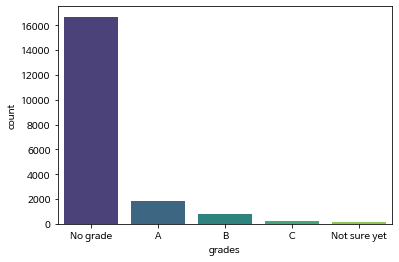

In [23]:
sns.countplot(df['grades'], order=df.grades.value_counts().head(5).index, palette='viridis')

좋은 지표로 쓰일 수 있는 feature 지만 결측치 (No grade) 가 너무 많아 추후 삭제하겠습니다.

##### Genders

In [24]:
df['gender'].value_counts()

unknown          15272
male              3464
andy               436
female             330
mostly_male        255
mostly_female      224
Name: gender, dtype: int64

##### Race

In [25]:
df['race'].value_counts()

nh_white    11227
hispanic     4999
nh_black     3755
Name: race, dtype: int64

In [26]:
df[['race', 'asian', 'hispanic', 'nh_black', 'nh_white']]

,race,asian,hispanic,nh_black,nh_white
0,hispanic,0.008548,0.731496,0.087095,0.172861
1,hispanic,0.008548,0.731496,0.087095,0.172861
2,hispanic,0.008548,0.731496,0.087095,0.172861
3,hispanic,0.008548,0.731496,0.087095,0.172861
4,hispanic,0.008548,0.731496,0.087095,0.172861
...,...,...,...,...,...
19995,nh_white,0.088680,0.073583,0.013858,0.823878
19996,nh_white,0.088680,0.073583,0.013858,0.823878
19997,nh_white,0.088680,0.073583,0.013858,0.823878
19998,nh_white,0.088680,0.073583,0.013858,0.823878


평가한 학생의 인종 중 제일 높은 비율의 인종을 나타내는 지표입니다.

`nh_white`, `nh_black` 중 nh는 Non-hispanic을 의미합니다.

##### For credits

해당 과목을 학점을 위해 수강했는지에 대한 여부를 나타내는 지표입니다.

In [27]:
df['for_credits'].value_counts()

Yes    4027
No       26
Name: for_credits, dtype: int64

##### Attendance

In [28]:
df['attence'].value_counts()

Mandatory        2819
Not Mandatory    1190
Name: attence, dtype: int64

`attence` feature는 attendance의 오타로 판단하여 이름을 재설정 하겠습니다.

In [29]:
df.rename(columns={'attence': 'attendance'}, inplace=True)
df.columns

Index(['professor_name', 'school_name', 'department_name', 'local_name',
       'state_name', 'year_since_first_review', 'star_rating', 'take_again',
       'diff_index', 'tag_professor', 'num_student', 'post_date',
       'name_onlines', 'name_not_onlines', 'student_star', 'student_difficult',
       'attendance', 'for_credits', 'would_take_agains', 'grades',
       'help_useful', 'help_not_useful', 'comments', 'word_comment', 'gender',
       'race', 'asian', 'hispanic', 'nh_black', 'nh_white',
       'gives_good_feedback', 'caring', 'respected', 'participation_matters',
       'clear_grading_criteria', 'skip_class', 'amazing_lectures',
       'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read',
       'lots_of_homework', 'accessible_outside_class', 'lecture_heavy',
       'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy',
       'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline'],
      dtype='object')

In [30]:
print('attendance column 결측치 개수:', df['attendance'].isna().sum())

attendance column 결측치 개수: 15972


결측치가 너무 많지만 데이터 전처리를 통한  활용 가능성이 있으니 삭제를 보류하겠습니다.

In [31]:
df['would_take_agains'].unique()

array(['Yes', nan, 'No'], dtype=object)

##### Take again

`take again` 는 해당 교수를 평가한 학생 중, 해당 교수의 다른 강의를 들을 의향이 있다고 응답한 학생의 비율을 의미합니다.

$$
take\;again = ({해당\;교수의\;다른\;강의를\;들을\;의향이\;있는\;학생\over\;해당\;교수를\;평가한\;전체\;학생\;수}) * 100
$$

In [32]:
df['take_again'].value_counts().sort_values(ascending=False)[:10]

100%    695
80%     213
83%     158
33%     140
50%     120
20%     100
88%     100
60%      99
57%      80
29%      80
Name: take_again, dtype: int64

In [33]:
print('전체 데이터 중 Take again column의 결측치 비율:', round((df['take_again'].isna().sum() / df.shape[0])*100,2), '%')

전체 데이터 중 Take again column의 결측치 비율: 85.0 %


In [34]:
df['take_again'] = df['take_again'].str.rstrip('%').astype('float') / 100
df['take_again']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
19995   NaN
19996   NaN
19997   NaN
19998   NaN
19999   NaN
Name: take_again, Length: 19981, dtype: float64

In [35]:
df['take_again'].unique()

array([ nan, 0.83, 0.33, 1.  , 0.2 , 0.09, 0.4 , 0.5 , 0.57, 0.86, 0.37,
       0.8 , 0.21, 0.88, 0.6 , 0.25, 0.85, 0.89, 0.62, 0.71, 0.44, 0.36,
       0.68, 0.82, 0.17, 0.63, 0.92, 0.22, 0.29, 0.43, 0.42, 0.1 , 0.16,
       0.78, 0.06, 0.75, 0.66, 0.67, 0.73, 0.23, 0.64, 0.24, 0.79, 0.56])

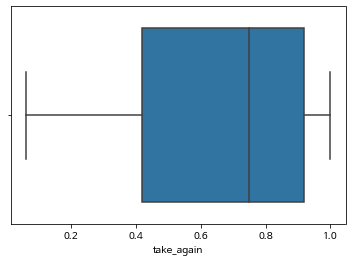

In [36]:
sns.boxplot(df['take_again'])

In [37]:
print('결측치 대체 전 take_again 평균 값', round(df['take_again'].dropna().mean(),2), '중앙 값', round(df['take_again'].dropna().median(),2))

결측치 대체 전 take_again 평균 값 0.67 중앙 값 0.75


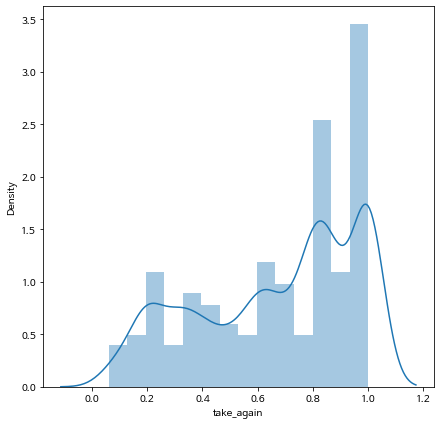

In [38]:
plt.figure(figsize=(7, 7))
sns.distplot(df['take_again'])
plt.show()

데이터의 분포가 left-skewed 이기 때문에 결측치를 중앙값으로 대체하려했으나,

결측치의 양이 너무 많아 하나의 값으로 결측치를 대체하게되면 너무 값이 몰릴 것 같다고 생각하여 `ffill`을 사용하여 결측치를 대체하겠습니다.

In [39]:
df['take_again'] = df['take_again'].fillna(method='ffill')

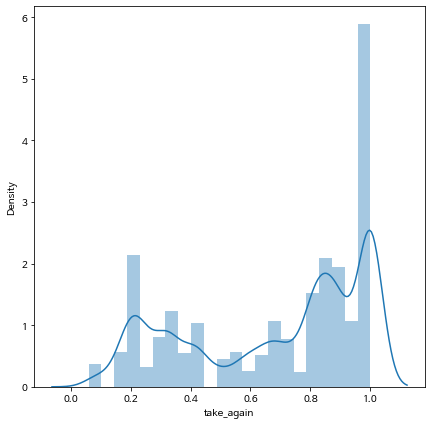

In [40]:
plt.figure(figsize=(7, 7))
sns.distplot(df['take_again'])
plt.show()

In [41]:
print('결측치 대체 후 take_again 평균 값', round(df['take_again'].dropna().mean(),2), '중앙 값', round(df['take_again'].dropna().median(),2))

결측치 대체 후 take_again 평균 값 0.68 중앙 값 0.8


`take again` feature를 생성했기 때문에 `would_take_agains` feature는 삭제하겠습니다.

In [42]:
df = df.drop(['would_take_agains'], axis=1, errors='ignore')
df.shape

(19981, 50)

##### Tag professor

In [43]:
df['tag_professor'].unique()[:5]

array(['Hilarious (2)  GROUP PROJECTS (2)  Gives good feedback (1)',
       "Gives good feedback (6)  Participation matters (3)  Respected (3)  Hilarious (3)  Caring (2)  Skip class? You won\\'t pass. (2)  GROUP PROJECTS (1)  Tough Grader (1)  GRADED BY FEW THINGS (1)  Amazing lectures (1)  Get ready to read (1)  Clear grading criteria (1)",
       nan,
       'Tough Grader (2)  Participation matters (2)  LECTURE HEAVY (1)  Inspirational (1)  TEST HEAVY (1)  Hilarious (1)',
       "Tough Grader (10)  Skip class? You won\\'t pass. (1)  Get ready to read (1)"],
      dtype=object)

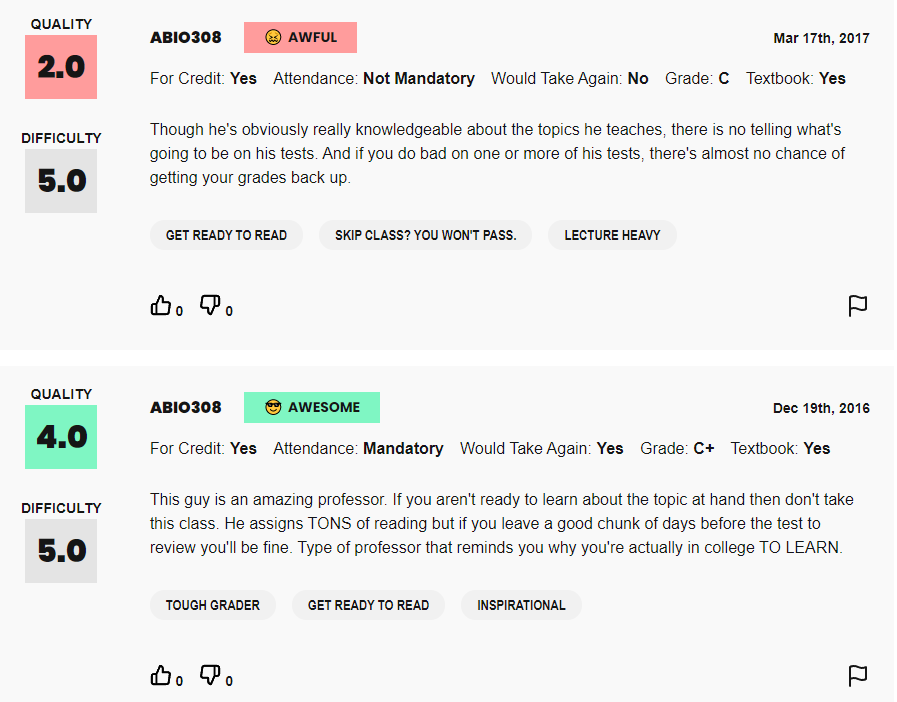

> 교수 평가 항목에 붙는 태그

어떤 태그들이 있는지 확인

In [44]:
browse_feat = df['tag_professor'].dropna().values
browse_feat

array(['Hilarious (2)  GROUP PROJECTS (2)  Gives good feedback (1)',
       'Hilarious (2)  GROUP PROJECTS (2)  Gives good feedback (1)',
       'Hilarious (2)  GROUP PROJECTS (2)  Gives good feedback (1)', ...,
       "BEWARE OF POP QUIZZES (4)  Amazing lectures (3)  Inspirational (3)  Skip class? You won\\'t pass. (2)  Tough Grader (2)  Hilarious (2)  ACCESSIBLE OUTSIDE CLASS (1)  Respected (1)  EXTRA CREDIT (1)  Participation matters (1)  GRADED BY FEW THINGS (1)  Caring (1)",
       "BEWARE OF POP QUIZZES (4)  Amazing lectures (3)  Inspirational (3)  Skip class? You won\\'t pass. (2)  Tough Grader (2)  Hilarious (2)  ACCESSIBLE OUTSIDE CLASS (1)  Respected (1)  EXTRA CREDIT (1)  Participation matters (1)  GRADED BY FEW THINGS (1)  Caring (1)",
       "BEWARE OF POP QUIZZES (4)  Amazing lectures (3)  Inspirational (3)  Skip class? You won\\'t pass. (2)  Tough Grader (2)  Hilarious (2)  ACCESSIBLE OUTSIDE CLASS (1)  Respected (1)  EXTRA CREDIT (1)  Participation matters (1)  GRADED B

In [45]:
result = [re.sub(r'[\s]+\([\d]+\)', '', x).lower().strip() for x in browse_feat]
result[:10]

['hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback',
 'hilarious  group projects  gives good feedback']

In [46]:
counter = defaultdict(int)

for item in str(result).split('  '):
  if len(item) < 1:
    continue
  counter[item] += 1

valid_tags = sorted(counter.items(), key=lambda x:x[1], reverse=True)[:20]
valid_tags

[('tough grader', 4507),
 ('gives good feedback', 4396),
 ("skip class? you won\\\\'t pass.", 4198),
 ('respected', 3970),
 ('participation matters', 3816),
 ('caring', 3568),
 ('clear grading criteria', 3555),
 ('get ready to read', 3159),
 ('amazing lectures', 3000),
 ('lecture heavy', 2920),
 ('lots of homework', 2849),
 ('hilarious', 2767),
 ('inspirational', 2735),
 ('accessible outside class', 2088),
 ('extra credit', 1791),
 ('test heavy', 1638),
 ('graded by few things', 1560),
 ('group projects', 1227),
 ('so many papers', 1194),
 ('beware of pop quizzes', 1008)]

In [47]:
tags = []
for i in range(len(valid_tags)):
  tags.append(valid_tags[i][0])
tags

['tough grader',
 'gives good feedback',
 "skip class? you won\\\\'t pass.",
 'respected',
 'participation matters',
 'caring',
 'clear grading criteria',
 'get ready to read',
 'amazing lectures',
 'lecture heavy',
 'lots of homework',
 'hilarious',
 'inspirational',
 'accessible outside class',
 'extra credit',
 'test heavy',
 'graded by few things',
 'group projects',
 'so many papers',
 'beware of pop quizzes']

In [48]:
tags = [re.sub('(\\\\)', '', x) for x in tags]
tags = [re.sub(' ', '_', x) for x in tags]
tags

['tough_grader',
 'gives_good_feedback',
 "skip_class?_you_won't_pass.",
 'respected',
 'participation_matters',
 'caring',
 'clear_grading_criteria',
 'get_ready_to_read',
 'amazing_lectures',
 'lecture_heavy',
 'lots_of_homework',
 'hilarious',
 'inspirational',
 'accessible_outside_class',
 'extra_credit',
 'test_heavy',
 'graded_by_few_things',
 'group_projects',
 'so_many_papers',
 'beware_of_pop_quizzes']

> tag_professor column에서 추출한 feature와 기존의 column들 중 겹치지 않는 부분이 있는지 체크해보겠습니다.

In [49]:
df_feat = df.columns
df_feat

Index(['professor_name', 'school_name', 'department_name', 'local_name',
       'state_name', 'year_since_first_review', 'star_rating', 'take_again',
       'diff_index', 'tag_professor', 'num_student', 'post_date',
       'name_onlines', 'name_not_onlines', 'student_star', 'student_difficult',
       'attendance', 'for_credits', 'grades', 'help_useful', 'help_not_useful',
       'comments', 'word_comment', 'gender', 'race', 'asian', 'hispanic',
       'nh_black', 'nh_white', 'gives_good_feedback', 'caring', 'respected',
       'participation_matters', 'clear_grading_criteria', 'skip_class',
       'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious',
       'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class',
       'lecture_heavy', 'extra_credit', 'graded_by_few_things',
       'group_projects', 'test_heavy', 'so_many_papers',
       'beware_of_pop_quizzes', 'IsCourseOnline'],
      dtype='object')

In [50]:
np.setdiff1d(tags, df_feat)

array(["skip_class?_you_won't_pass."], dtype='<U27')

`skip_class?_you_won't_pass.` 를 제외하고는 모두 기존 데이터 내 존재하는 feature 입니다.

데이터 내 해당 feature를 대체할 수 있는 수단으로 `attendance` 또는 `skip_class` 가 있습니다.

> Skip class? you won't pass == True 일 경우 출석체크가 필수라는 뜻으로 해석하겠습니다.

In [51]:
tag_skip = df['tag_professor'].str.contains('Skip class?', na=False)
tag_skip

0        False
1        False
2        False
3        False
4        False
         ...  
19995     True
19996     True
19997     True
19998     True
19999     True
Name: tag_professor, Length: 19981, dtype: bool

`tag_professor` feature 내 `Skip class? you won't pass` 태그가 존재하는 경우 1

아닌 경우 0 을 표시하는 `is_mandatory` feature 생성

In [52]:
target_map = {True:1, False:0}

df['is_mandatory'] = tag_skip.apply(lambda x: target_map[x])
df['is_mandatory']

0        0
1        0
2        0
3        0
4        0
        ..
19995    1
19996    1
19997    1
19998    1
19999    1
Name: is_mandatory, Length: 19981, dtype: int64

In [53]:
df['is_mandatory'].value_counts()

0    14391
1     5590
Name: is_mandatory, dtype: int64

In [54]:
df['skip_class'].value_counts()

0    14391
1     5590
Name: skip_class, dtype: int64

`is_mandatory`와 기존의 `skip_class`가 정확히 일치하는 것을 확인했습니다.

출석 관련 feature는 `is_mandatory` 만 사용하고,

결측치가 많은 `attendance`, `skip_class` feature는 삭제하도록 하겠습니다.

##### Department name

In [55]:
df['department_name'].value_counts()[:20]

English department              2260
Mathematics department          1769
Psychology department           1336
Biology department              1077
History department              1050
Communication department         758
Business department              703
Computer Science department      654
Education department             589
Chemistry department             582
Sociology department             559
Philosophy department            510
Fine Arts department             478
Languages department             477
Political Science department     433
Economics department             389
Science department               381
Geography department             344
Music department                 329
Engineering department           325
Name: department_name, dtype: int64

Text(0, 0.5, 'Count')

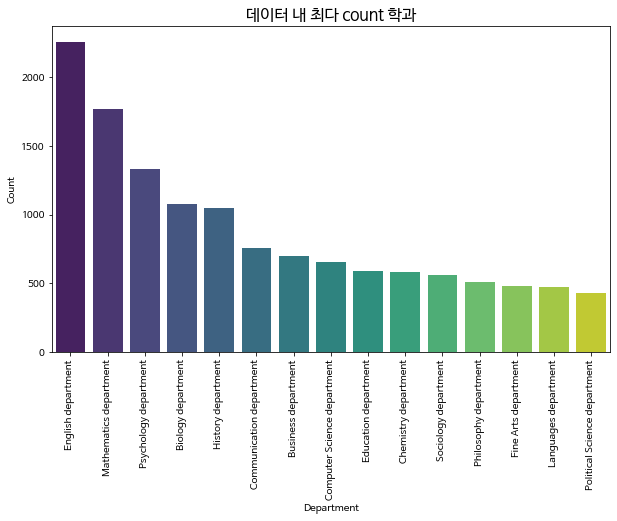

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot('department_name', data=df, order=df.department_name.value_counts().head(15).index, palette='viridis')
plt.xlabel('Department')
plt.xticks(rotation=90)
plt.title('데이터 내 최다 count 학과', fontsize=16)
plt.ylabel('Count')

많이 집계된 학과 중

`난이도가 높다고 평가된 학과`와 `교수의 평점이 평균적으로 높은 학과`를 시각화해보겠습니다

In [57]:
depart_diff = df.groupby('department_name')['diff_index'].aggregate(['mean', 'count']).sort_values(by=['count'], ascending=[False])[:15]
depart_diff = depart_diff.rename(columns={'mean': 'difficulty'}).sort_values('difficulty', ascending=False).reset_index()
depart_diff

,department_name,difficulty,count
0,Chemistry department,3.501375,582
1,Biology department,3.362953,1077
2,History department,3.067714,1050
3,Political Science department,3.067667,433
4,English department,2.995619,2260
5,Computer Science department,2.988991,654
6,Fine Arts department,2.984100,478
7,Mathematics department,2.954890,1769
8,Philosophy department,2.906078,510
9,Education department,2.864177,589


In [58]:
depart_rate = df.groupby('department_name')['star_rating'].aggregate(['mean', 'count']).sort_values(by=['count'], ascending=[False])[:15]
depart_rate = depart_rate.rename(columns={'mean': 'star_rating'}).sort_values('star_rating', ascending=False).reset_index()
depart_rate

,department_name,star_rating,count
0,Languages department,3.898742,477
1,Political Science department,3.846882,433
2,English department,3.774867,2260
3,Psychology department,3.703892,1336
4,Communication department,3.696966,758
5,History department,3.656476,1050
6,Sociology department,3.655098,559
7,Biology department,3.647168,1077
8,Education department,3.644822,589
9,Philosophy department,3.634314,510


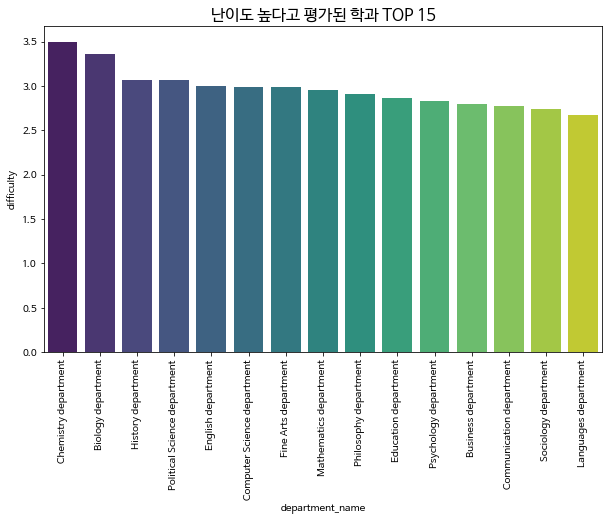

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(data = depart_diff, x="department_name", y="difficulty", order=depart_diff.department_name, palette='viridis')
plt.title("난이도 높다고 평가된 학과 TOP 15", fontsize=16)
plt.xticks(rotation=90)
plt.show()

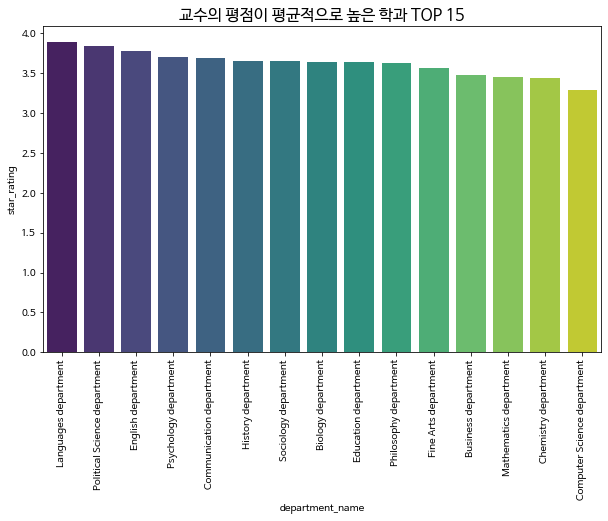

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(data = depart_rate, x="department_name", y="star_rating", order=depart_rate.department_name, palette='viridis')
plt.title('교수의 평점이 평균적으로 높은 학과 TOP 15', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [61]:
cat_feat = df.select_dtypes(include='object').columns
df[cat_feat].head()

,professor_name,school_name,department_name,local_name,state_name,tag_professor,name_onlines,name_not_onlines,attendance,for_credits,grades,comments,gender,race
0,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,Hilarious (2) GROUP PROJECTS (2) Gives good ...,NAN,ASTR122,Mandatory,Yes,B,"This class is hard, but its a two-in-one gen-e...",unknown,hispanic
1,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,Hilarious (2) GROUP PROJECTS (2) Gives good ...,NAN,ASTR122,Not Mandatory,NaN,A,Definitely going to choose Prof. Looney\'s cla...,unknown,hispanic
2,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,Hilarious (2) GROUP PROJECTS (2) Gives good ...,NAN,ASTR330,NaN,Yes,No grade,I overall enjoyed this class because the assig...,unknown,hispanic
3,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,Hilarious (2) GROUP PROJECTS (2) Gives good ...,NAN,ASTR1008WKS,Mandatory,Yes,A,"Yes, it\'s possible to get an A but you\'ll de...",unknown,hispanic
4,Leslie Looney,University Of Illinois at Urbana-Champaign,Astronomy department,Champaign\xe2\x80\x93Urbana,IL,Hilarious (2) GROUP PROJECTS (2) Gives good ...,NAN,ASTR150,Mandatory,NaN,No grade,Professor Looney has great knowledge in Astron...,unknown,hispanic


#### 수치형 features

In [62]:
num_feat = df.select_dtypes(include='number').columns
df[num_feat].head()

,year_since_first_review,star_rating,take_again,diff_index,num_student,student_star,student_difficult,help_useful,help_not_useful,word_comment,...,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline,is_mandatory
0,11.0,4.7,NaN,2.0,26.0,5.0,3.0,0.0,0.0,44.0,...,0,0,0,0,1,0,0,0,0,0
1,11.0,4.7,NaN,2.0,26.0,5.0,2.0,0.0,0.0,38.0,...,0,0,0,0,1,0,0,0,0,0
2,11.0,4.7,NaN,2.0,26.0,4.0,3.0,0.0,0.0,32.0,...,0,0,0,0,1,0,0,0,0,0
3,11.0,4.7,NaN,2.0,26.0,5.0,3.0,0.0,0.0,64.0,...,0,0,0,0,1,0,0,0,0,0
4,11.0,4.7,NaN,2.0,26.0,5.0,1.0,0.0,0.0,57.0,...,0,0,0,0,1,0,0,0,0,0


In [63]:
num_feat

Index(['year_since_first_review', 'star_rating', 'take_again', 'diff_index',
       'num_student', 'student_star', 'student_difficult', 'help_useful',
       'help_not_useful', 'word_comment', 'asian', 'hispanic', 'nh_black',
       'nh_white', 'gives_good_feedback', 'caring', 'respected',
       'participation_matters', 'clear_grading_criteria', 'skip_class',
       'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious',
       'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class',
       'lecture_heavy', 'extra_credit', 'graded_by_few_things',
       'group_projects', 'test_heavy', 'so_many_papers',
       'beware_of_pop_quizzes', 'IsCourseOnline', 'is_mandatory'],
      dtype='object')

##### Preview

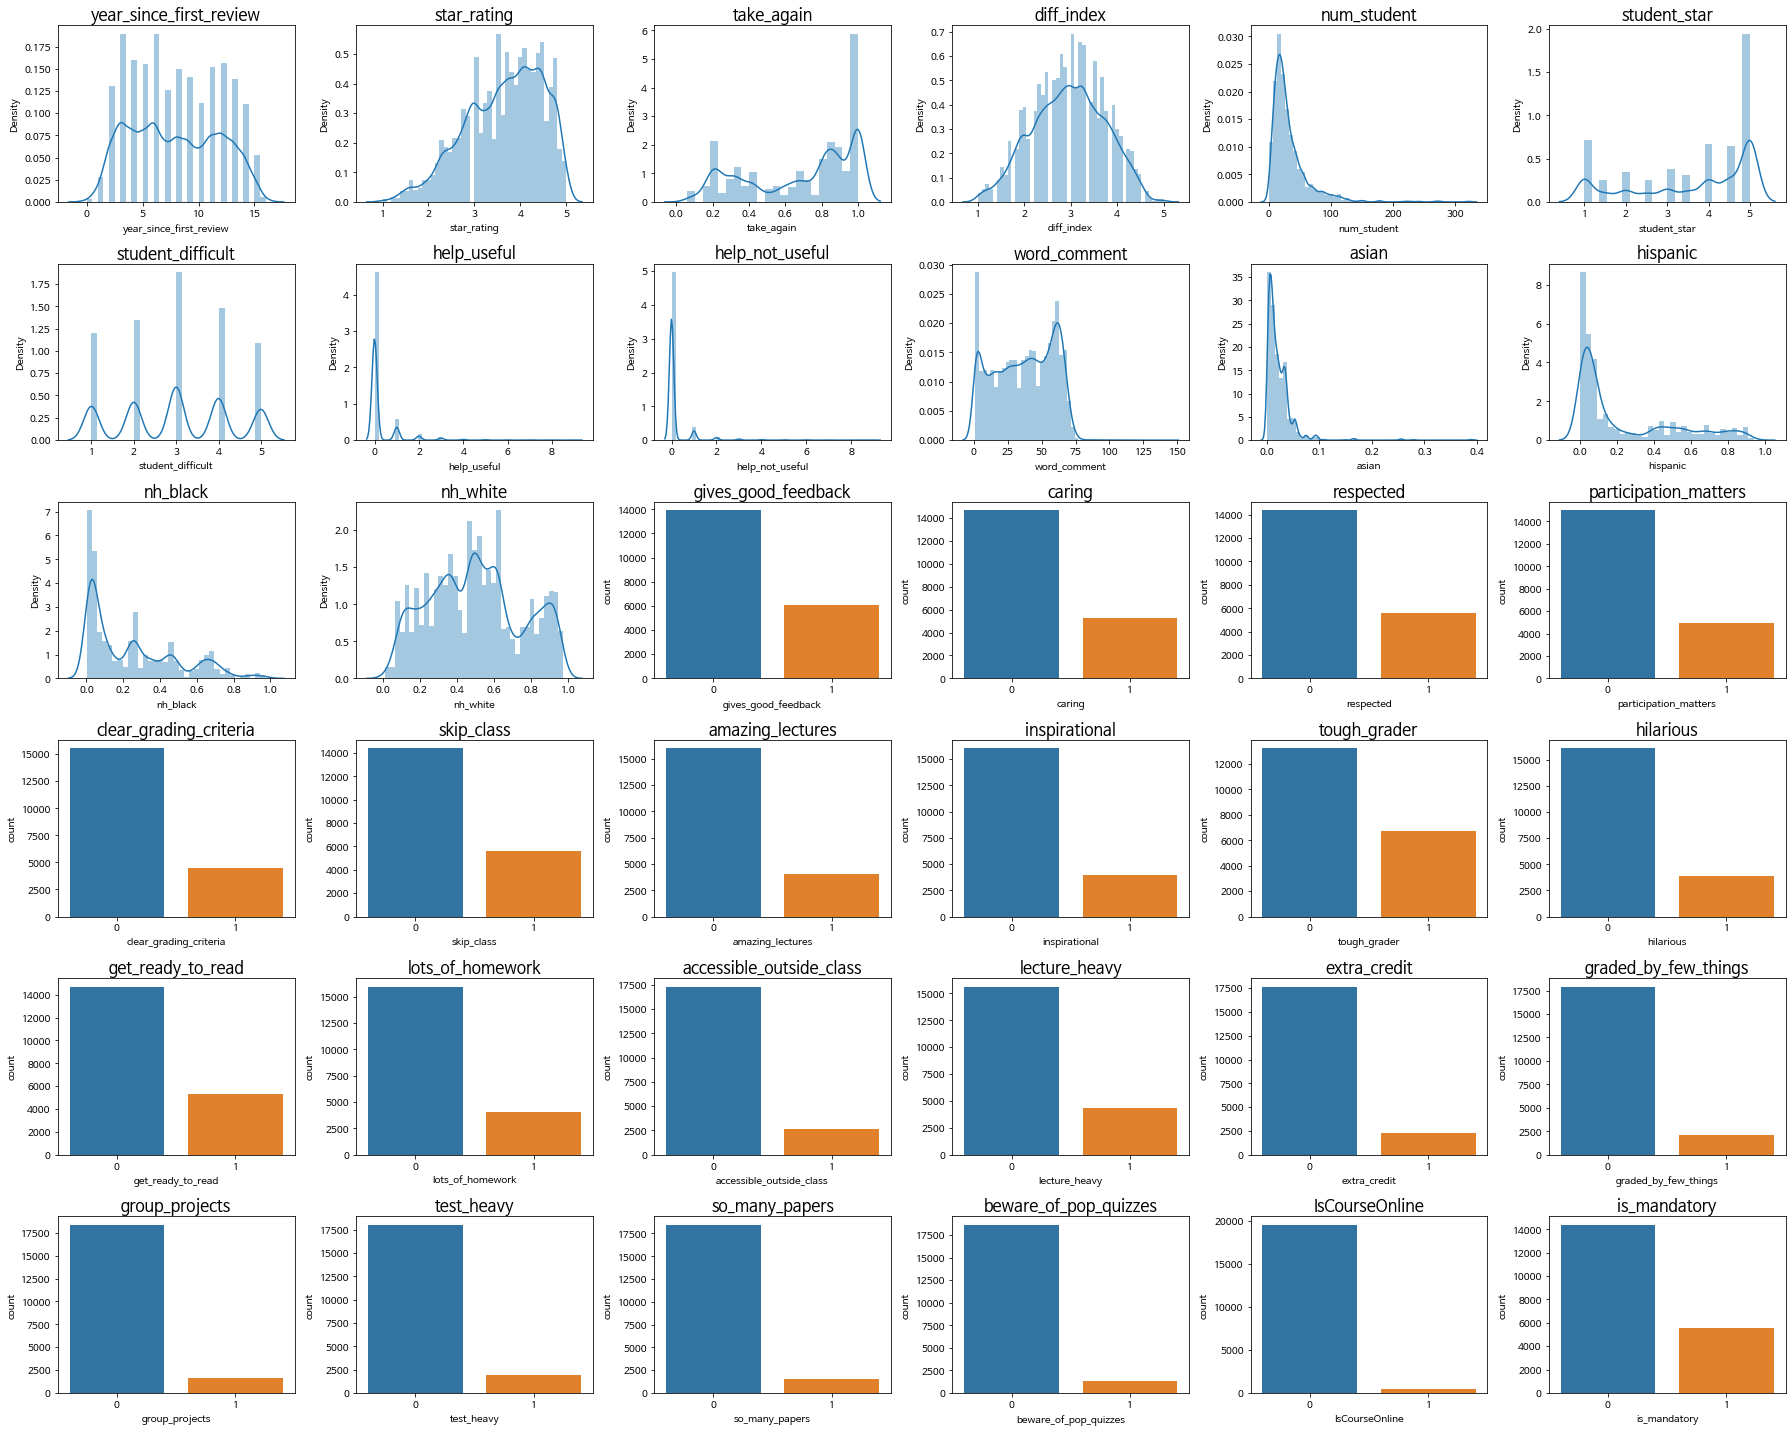

In [64]:
df_num = df[num_feat].copy()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(25,20))

for idx, col in enumerate(df_num):
  if df[col].nunique() == 2:
    sns.countplot(df[col], ax = axes[idx//6, idx%6])
    axes[idx//6, idx%6].set_title(col, fontsize=16)
  else:
    sns.distplot(df[col], ax = axes[idx//6, idx%6])
    axes[idx//6, idx%6].set_title(col, fontsize=16)
plt.tight_layout()
plt.show()

##### Student star

Target feature로 활용될 지표로써 교수의 평점을 나타내는 지표입니다.

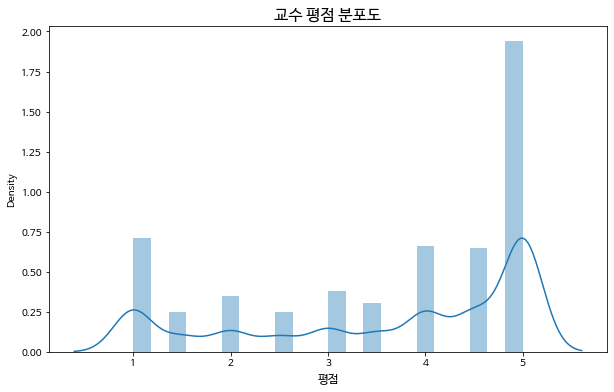

In [65]:
plt.figure(figsize=(10,6))
sns.distplot(df['student_star'])
plt.xlabel('평점', fontsize=12)
plt.title('교수 평점 분포도', fontsize=16)
plt.show()

##### Take again

해당 교수를 평가한 학생 중, 해당 교수의 다른 강의를 들을 의향이 있다고 응답한 학생의 비율을 의미합니다.

범주형 feature 였으나 전처리를 통해 수치형 feature로 변환했습니다.

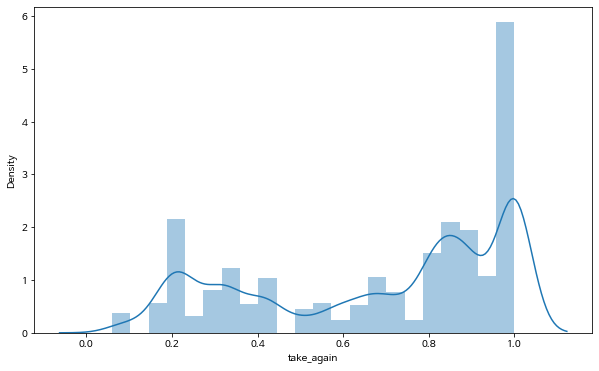

In [66]:
plt.figure(figsize=(10,6))
sns.distplot(df['take_again'])
plt.show()

##### Student difficult

모든 학생이 해당 교수에게 부여한 강좌의 난이도입니다.


1점이 매우 쉬움을 의미하며, 5점은 매우 어려움을 의미합니다

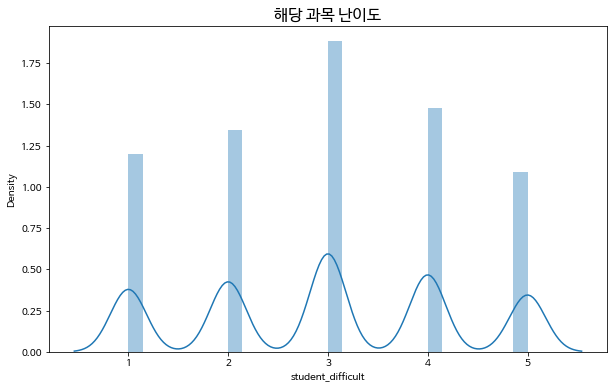

In [67]:
plt.figure(figsize=(10,6))
sns.distplot(df['student_difficult'])
plt.title('해당 과목 난이도', fontsize=16)
plt.show()

##### Word comment

교수를 평가하는 코멘트의 길이와 교수 평점사이의 관계를 시각화 해보겠습니다

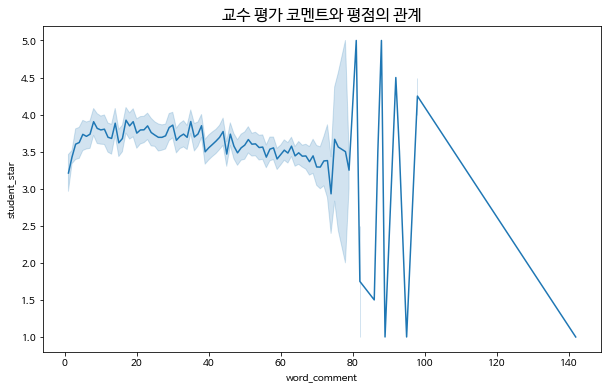

In [68]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='word_comment', y = 'student_star')
plt.title('교수 평가 코멘트와 평점의 관계', fontsize=16)
plt.show()

> 데이터의 양이 비교적 적은 80자 이상의 코멘트를 제외하고 확인해보겠습니다

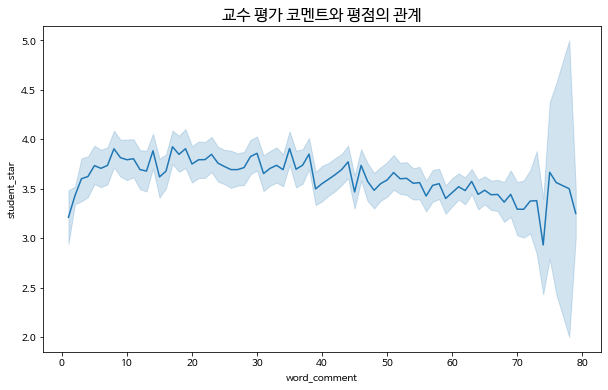

In [69]:
under_80 = df[df['word_comment'] < 80]
plt.figure(figsize=(10,6))
sns.lineplot(data=under_80, x='word_comment', y = 'student_star')
plt.title('교수 평가 코멘트와 평점의 관계', fontsize=16)
plt.show()

In [70]:
pearsonr(under_80['word_comment'], under_80['student_star'])[0]

-0.0501815048245976

In [71]:
df[df['word_comment'] > 80]['comments'].values[0]

'Pat Ledbetter is extremely knowledgeable and certainly knows this subject inside and out. She is very involved with the online students, as she would email me right back if ever I had any issues or questions. She interacts with the class in the discussion forums, as well. I must tell you, however, that you DO need to DO THE WORK. She likes to assign writing papers and her tests can be challenging, but if you aim to learn and do the work YOU WILL LEARN! She is very good at what she does, but she is pretty tough.'

In [72]:
df[df['word_comment'] > 80]['comments'].values[2]

"don\\'t take his class if you\\'re a ****, not if you\\'re a woman! why not transcend to substance? he\\'s not out to judge anyone personally. Art CAN be****ty. not just because it\\'s got no talent. personal working process & style has to been CRITICIZED to improve. self-involved catharcism is why no one gives a**** about art. we have to take drastic steps towards art that actually ROCKS. Paul has crystalized this vision that may never be seen again if it\\'s been seen before. prof\\'s don\\'t come this UNstuffy."

##### Respected

교수 평가 관련 태그 중 `Respected`와 교수의 평점의 관계를 살펴보겠습니다.

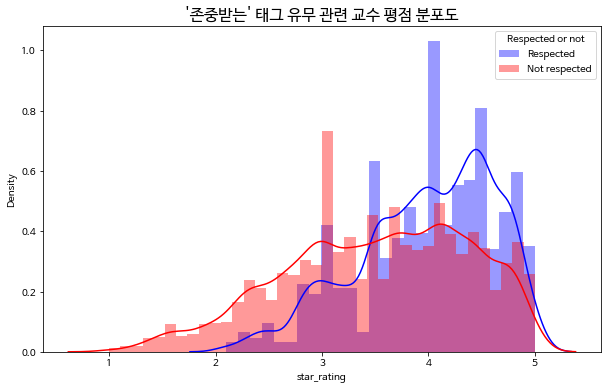

In [73]:
plt.figure(figsize=(10,6))
sns.distplot(df[df.respected == 1]['star_rating'],color="blue", label='Respected')
sns.distplot(df[df.respected == 0]['star_rating'],color="red", label='Not respected')
plt.title("'존중받는' 태그 유무 관련 교수 평점 분포도", fontsize=16)
plt.legend(title='Respected or not')
plt.show()

존중받는 교수일수록 더 높은 평점 쪽으로 분포되어 있습니다.

> 교수 평가 요인과 평점과의 관계

교수 평가 요인중 몇개를 선정해 평점과의 관계를 확인해보겠습니다.

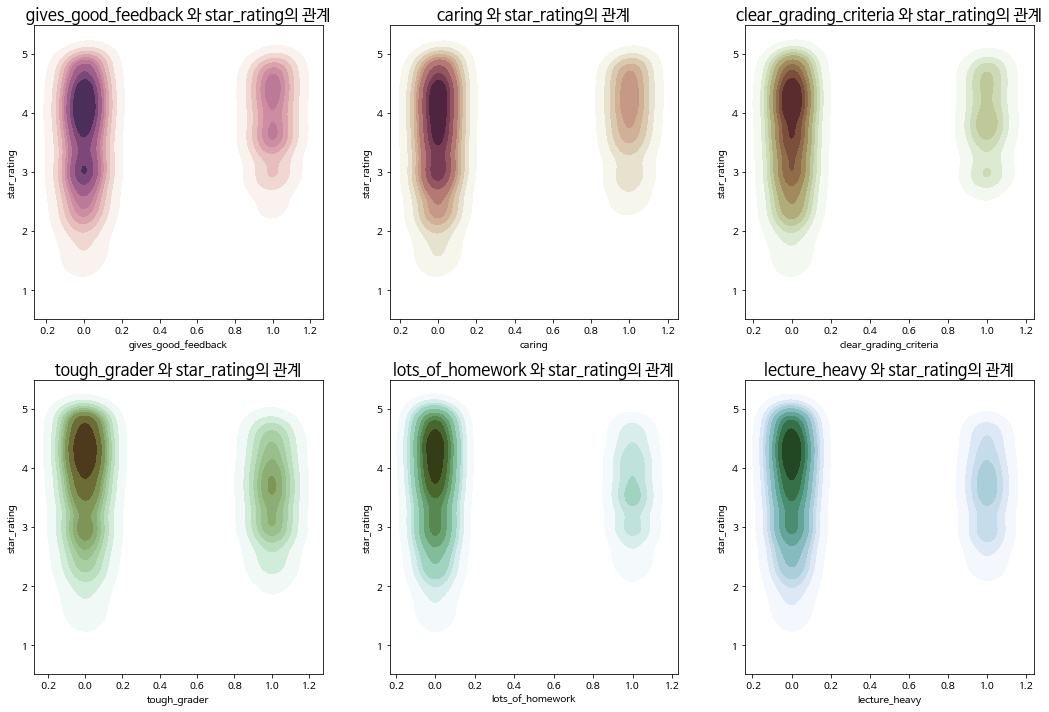

In [74]:
features = ['gives_good_feedback', 'caring','clear_grading_criteria', 'tough_grader','lots_of_homework', 'lecture_heavy']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for idx, feature in enumerate(features):
  sns.kdeplot(x=features[idx], y = 'star_rating', data=df, shade=True, cmap = sns.cubehelix_palette(start=idx*0.33, light=1, as_cmap=True), ax=axes[idx//3, idx%3])
  axes[idx//3, idx%3].set_title(f'{feature} 와 star_rating의 관계', fontsize=16)
plt.tight_layout()
plt.show()

> Feature 제거

결측치를 대체할 수단이 없다고 판단되거나 모델 학습에 불필요하다고 생각하는 feature 들을 제거하겠습니다.


In [75]:
cat_feat = df.select_dtypes(include='object').columns
num_feat = df.select_dtypes(include='number').columns
print(cat_feat, num_feat, sep='\n')

Index(['professor_name', 'school_name', 'department_name', 'local_name',
       'state_name', 'tag_professor', 'name_onlines', 'name_not_onlines',
       'attendance', 'for_credits', 'grades', 'comments', 'gender', 'race'],
      dtype='object')
Index(['year_since_first_review', 'star_rating', 'take_again', 'diff_index',
       'num_student', 'student_star', 'student_difficult', 'help_useful',
       'help_not_useful', 'word_comment', 'asian', 'hispanic', 'nh_black',
       'nh_white', 'gives_good_feedback', 'caring', 'respected',
       'participation_matters', 'clear_grading_criteria', 'skip_class',
       'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious',
       'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class',
       'lecture_heavy', 'extra_credit', 'graded_by_few_things',
       'group_projects', 'test_heavy', 'so_many_papers',
       'beware_of_pop_quizzes', 'IsCourseOnline', 'is_mandatory'],
      dtype='object')


In [76]:
df = df.drop(['professor_name', 'school_name', 'department_name', 'help_useful', 'help_not_useful', 'race',
              'local_name', 'state_name', 'tag_professor', 'name_onlines', 'gender',
              'name_not_onlines', 'attendance', 'for_credits', 'grades', 'comments'], axis=1, errors='ignore')
df = df.drop(['year_since_first_review', 'star_rating', 'diff_index', 'asian',
              'hispanic', 'nh_black', 'nh_white','skip_class','post_date'], axis=1, errors='ignore')
print(df.shape)

(19981, 26)


In [77]:
df.head()

,take_again,num_student,student_star,student_difficult,word_comment,gives_good_feedback,caring,respected,participation_matters,clear_grading_criteria,...,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline,is_mandatory
0,NaN,26.0,5.0,3.0,44.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,NaN,26.0,5.0,2.0,38.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,NaN,26.0,4.0,3.0,32.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,NaN,26.0,5.0,3.0,64.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,NaN,26.0,5.0,1.0,57.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


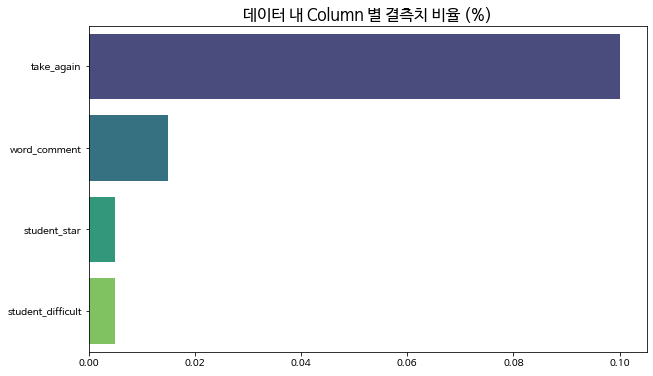

In [78]:
plot_missing_data(df)

In [79]:
df = df.dropna()
df.shape

(19958, 26)

### Target feature 생성

> 학생들이 수강평에 남긴 `student_star`를 활용해 `overall_quality` 지표를 생성하겠습니다.

In [81]:
def make_label(x):
  if 1 <= x < 2:
    return 'Not recommended'
  else:
    return 'Recommended'

In [82]:
df['recommended'] = df['student_star'].apply(make_label)
df['recommended'].value_counts()

Recommended        16458
Not recommended     3500
Name: recommended, dtype: int64

In [83]:
df = df.drop(['student_star'], axis=1, errors='ignore')
df.shape

(19958, 26)

#### 상관성 확인

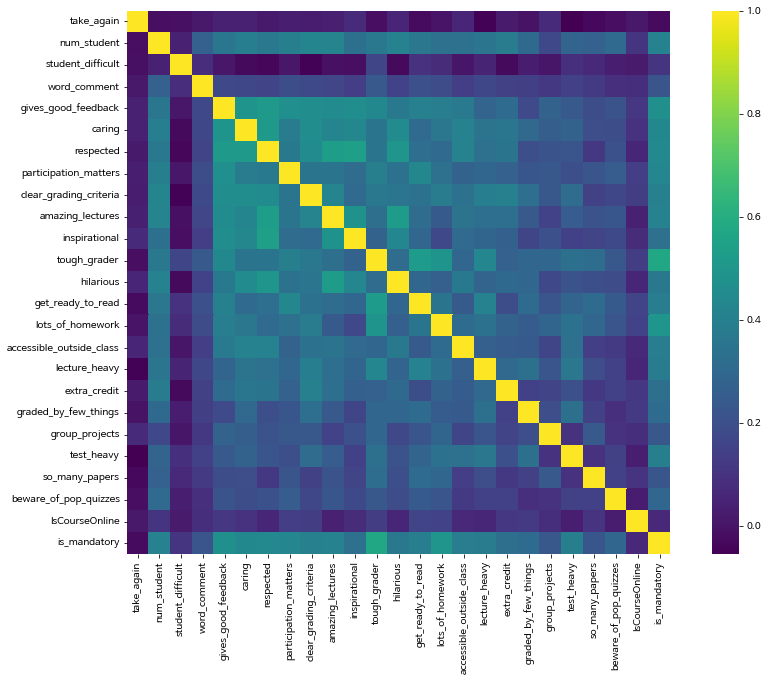

In [84]:
plt.figure(figsize=(15, 10))

cols = df.corr().index
sns.heatmap(df.corr(), yticklabels=cols, xticklabels=cols, cmap='viridis', square=True)
plt.show()

> 컬럼들 간 Pearson R 계수

In [85]:
num_feat = df.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [86]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.7]
high_corr_num

array([], shape=(0, 2), dtype='<U24')

수치형 데이터 내 상관 계수가 높은 관계가 발견되지 않았습니다.
상관 계수가 0.5를 넘는 지표를 확인해보겠습니다.

In [87]:
middle_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.5]
middle_corr_num

array([['gives_good_feedback', 'respected'],
       ['caring', 'respected'],
       ['respected', 'amazing_lectures'],
       ['respected', 'inspirational'],
       ['amazing_lectures', 'hilarious'],
       ['tough_grader', 'get_ready_to_read'],
       ['tough_grader', 'is_mandatory']], dtype='<U24')

In [88]:
# 상관계수 정렬
correlation = df.corr()

conc_corr = correlation.iloc[:,1].sort_values(ascending=False)

# 상위 5개
conc_corr[1:].head(5)

clear_grading_criteria    0.424831
amazing_lectures          0.422827
hilarious                 0.407975
is_mandatory              0.407204
participation_matters     0.395403
Name: num_student, dtype: float64

## 학습 준비

In [89]:
num_feat = df.select_dtypes('number').columns
df_num = df[num_feat].copy()
print(df_num.nunique().sort_values())

hilarious                     2
beware_of_pop_quizzes         2
so_many_papers                2
test_heavy                    2
group_projects                2
graded_by_few_things          2
extra_credit                  2
lecture_heavy                 2
accessible_outside_class      2
lots_of_homework              2
get_ready_to_read             2
IsCourseOnline                2
is_mandatory                  2
inspirational                 2
amazing_lectures              2
clear_grading_criteria        2
participation_matters         2
respected                     2
caring                        2
gives_good_feedback           2
tough_grader                  2
student_difficult             5
take_again                   43
word_comment                 89
num_student                 123
dtype: int64


### 데이터 셋 concat

In [90]:
train_final = pd.concat([df['recommended'], df_num], axis=1)
train_final.head()

,recommended,take_again,num_student,student_difficult,word_comment,gives_good_feedback,caring,respected,participation_matters,clear_grading_criteria,...,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline,is_mandatory
20,Recommended,0.83,22.0,2.0,39.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
21,Recommended,0.83,22.0,2.0,74.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
22,Recommended,0.83,22.0,3.0,67.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
23,Recommended,0.83,22.0,2.0,50.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
24,Recommended,0.83,22.0,4.0,35.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1


전처리 이후 중복값이 발생하여 제거해주겠습니다.


전처리 과정에서 `comments`와 같은 유니크한 feature를 삭제한 탓에 중복값이 발생한 것 같습니다.

In [91]:
print(train_final.shape)
train_final[train_final.duplicated(keep=False)]

(19958, 26)


,recommended,take_again,num_student,student_difficult,word_comment,gives_good_feedback,caring,respected,participation_matters,clear_grading_criteria,...,accessible_outside_class,lecture_heavy,extra_credit,graded_by_few_things,group_projects,test_heavy,so_many_papers,beware_of_pop_quizzes,IsCourseOnline,is_mandatory
22,Recommended,0.83,22.0,3.0,67.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
39,Recommended,0.83,22.0,3.0,67.0,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
42,Recommended,0.83,8.0,3.0,9.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,Not recommended,0.83,29.0,5.0,56.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
75,Not recommended,0.83,29.0,5.0,14.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,Recommended,0.57,18.0,4.0,64.0,0,1,1,1,0,...,1,0,1,1,0,0,0,1,0,1
19990,Recommended,0.57,18.0,4.0,64.0,0,1,1,1,0,...,1,0,1,1,0,0,0,1,0,1
19992,Recommended,0.57,18.0,4.0,55.0,0,1,1,1,0,...,1,0,1,1,0,0,0,1,0,1
19993,Recommended,0.57,18.0,4.0,64.0,0,1,1,1,0,...,1,0,1,1,0,0,0,1,0,1


In [92]:
train_final = train_final.drop_duplicates(keep='first')
train_final.shape

(18904, 26)

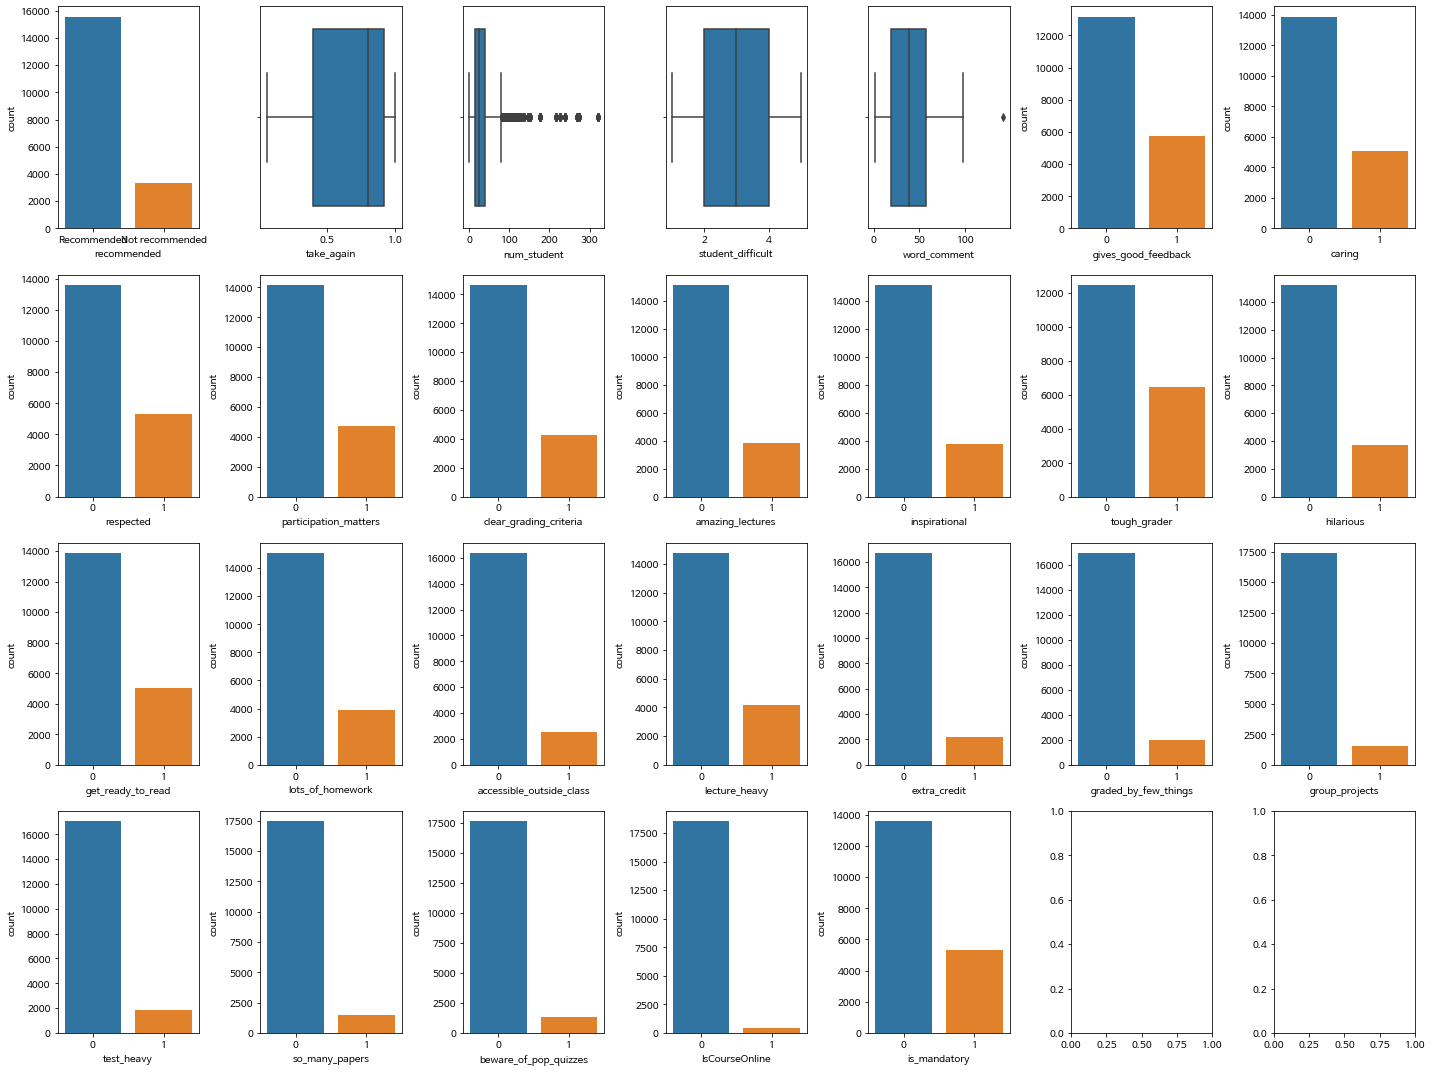

In [93]:
final_cols = train_final.columns

fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(20,15))

for idx, col in enumerate(final_cols):
  if train_final[col].nunique() == 2:
    sns.countplot(train_final[col], ax=axes[idx//7, idx%7])
  else:
    sns.boxplot(train_final[col], ax=axes[idx//7, idx%7])
plt.tight_layout()
plt.show()

> 학습에 영향을 미칠수 있는 outlier를 제거하겠습니다

In [94]:
def detect_outliers(df, features):
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        
        IQR = Q3 - Q1

        # outlier step
        upperfence = Q3 + (1.5 * IQR)
        lowerfence = Q1 - (1.5 * IQR)

        # 이상치 컬럼 리스트
        outlier_list_col = df[(df[col] < lowerfence) | (df[col] > upperfence)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    return outlier_indices

cols = ['word_comment', 'num_student']

Outliers_to_drop = detect_outliers(train_final, cols)

print(len(Outliers_to_drop))

1360


In [95]:
train_final = train_final.drop(Outliers_to_drop)
train_final.shape

(17544, 26)

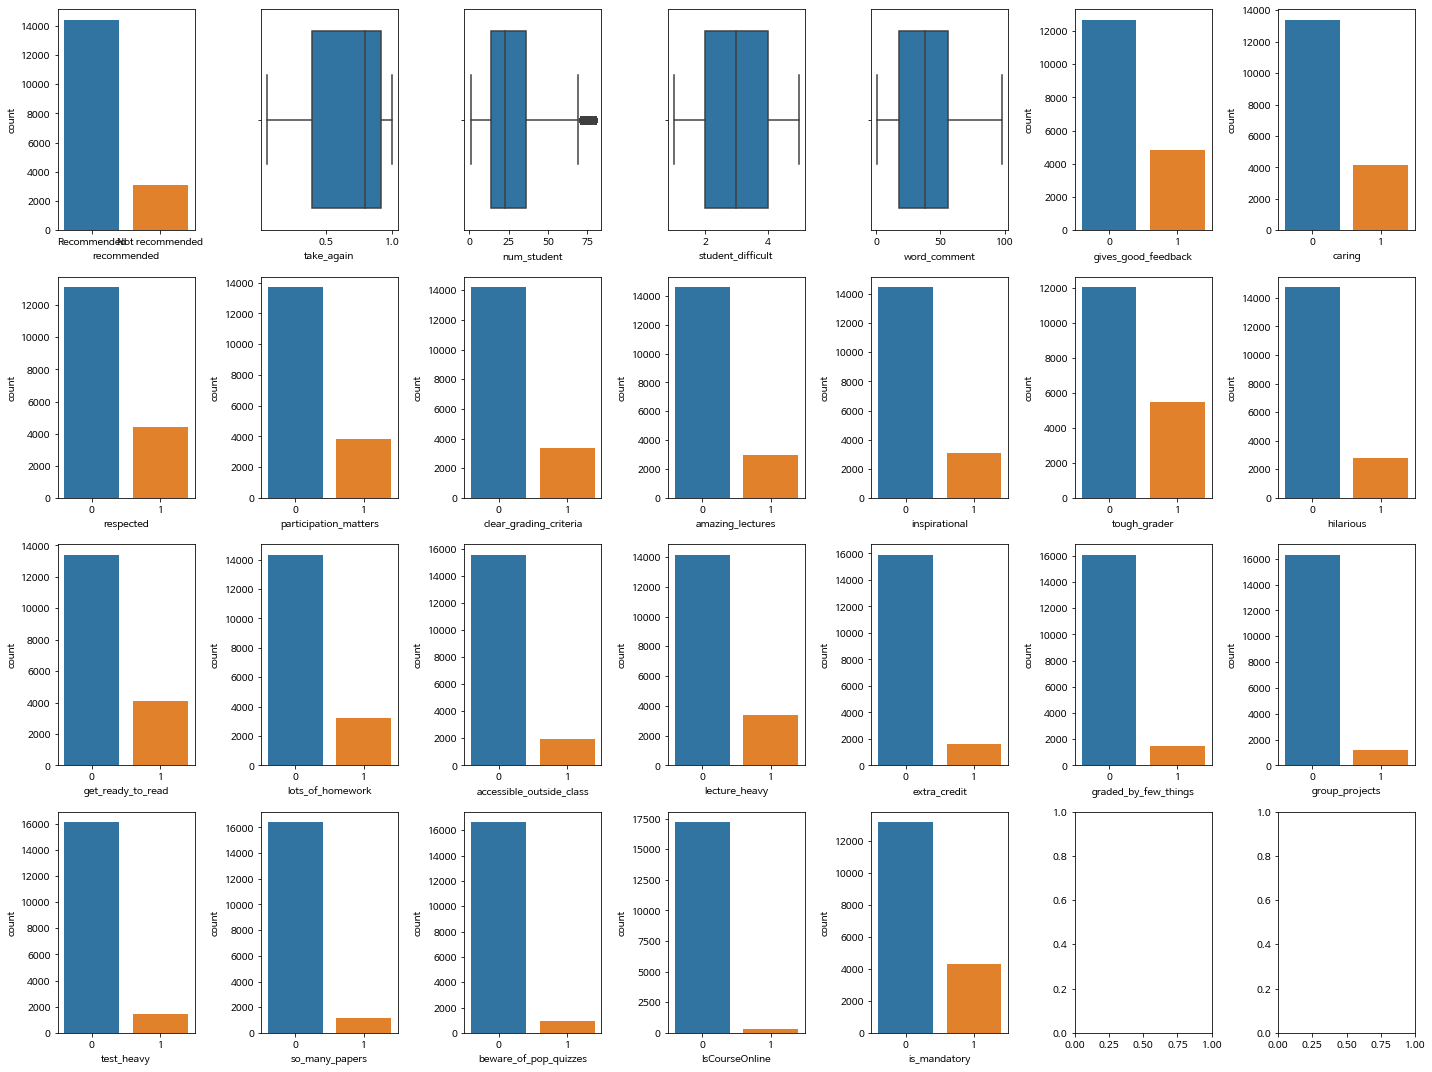

In [96]:
final_cols = train_final.columns

fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(20,15))

for idx, col in enumerate(final_cols):
  if train_final[col].nunique() == 2:
    sns.countplot(train_final[col], ax=axes[idx//7, idx%7])
  else:
    sns.boxplot(train_final[col], ax=axes[idx//7, idx%7])
plt.tight_layout()
plt.show()

In [97]:
X = train_final.drop(['recommended'], axis=1, errors='ignore')
y = train_final['recommended']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1214, stratify=y)

print('학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)

학습용 피처/레이블 데이터 세트:  (12280, 25) (12280,)
테스트용 피처/레이블 데이터 세트:  (5264, 25) (5264,)


### Scaling

Minmax scaler를 활용해 데이터 정규화를 진행하겠습니다.

In [99]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline

### 다양한 Classifier를 활용한 모델 생성과 Hyper parameter tuning

#### 모델 준비

In [100]:
models = {'DecisionTreeClassifier': DecisionTreeClassifier(),
          'LogisticRegression': LogisticRegression(),
          'RandomForestClassifier': RandomForestClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'XGBClassifier':XGBClassifier()}


params = {'DecisionTreeClassifier': [{'max_depth': [i for i in range(2, 11 , 2)], 
                                      'criterion':['gini', 'entropy']}],
          'LogisticRegression': [{'C': [1.0, 0.1, 0.01],
                                  'penalty': ['l2']}],
          'RandomForestClassifier': [{'n_estimators':[i for i in range(10, 101, 10)]}],             
          'GradientBoostingClassifier': [{'n_estimators': [i for i in range(20, 81,10)]}],
          'KNeighborsClassifier':[{'n_neighbors' : [i for i in range(5, 15, 2)]},
                                  {'metric' : ['euclidean','manhattan']}],
          'XGBClassifier': [{'n_estimators': [i for i in range(50, 350, 50)]}]}

#### 모델 생성

> 하나의 함수로 여러 Classifier 들에 대해 GridSearchCV 적용

`KNeighborsClassifier`는 confusion matrix를 위해 라벨을 따로 encoding 하겠습니다

In [101]:
y_train_knn = y_train.copy()

In [102]:
def encoder(x):
  if x == 'Recommended':
    return 1
  else:
    return 0

In [103]:
y_train_knn = y_train_knn.apply(encoder)
print(y_train.values[:15])
print(y_train_knn.values[:15])

['Recommended' 'Recommended' 'Recommended' 'Not recommended'
 'Not recommended' 'Recommended' 'Recommended' 'Recommended' 'Recommended'
 'Recommended' 'Recommended' 'Recommended' 'Recommended' 'Recommended'
 'Recommended']
[1 1 1 0 0 1 1 1 1 1 1 1 1 1 1]


In [104]:
y_test_knn = y_test.copy()
y_test_knn = y_test_knn.apply(encoder)
print(y_test.values[:15])
print(y_test_knn.values[:15])

['Recommended' 'Recommended' 'Recommended' 'Recommended' 'Recommended'
 'Recommended' 'Recommended' 'Not recommended' 'Not recommended'
 'Recommended' 'Recommended' 'Recommended' 'Recommended' 'Recommended'
 'Recommended']
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]


In [105]:
features = X.columns.tolist()
important_features_list = []

class_names = ['Not recommended','Recommended']
plt.figure(figsize=(20, 12))

def runclassifiers(X_train, y_train, y_train_knn, X_test, y_test, y_test_knn):

    idx = 0
    # 총 3 x 2, 6개의 그래프를 생성
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20, 15))


    # 각 평가 지표를 저장할 변수들 생성
    result_name = []
    result_summary1 = []
    result_precision = []
    result_recall = []
    result_f1_score = []
    result_acc_score = []
    result_best_score = []

    for name in models.keys():

        # estimator 와 parameter 를 가져온다
        est = models[name]
        est_params = params[name]

        if not est == KNeighborsClassifier():
          """
          최적 파라미터 탐색
          """
          # GridSearchCV 생성하여 fitting (cv=5)
          gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)   
          gscv.fit(X_train, y_train)
          # 가장 좋은 성능 지표를 저장한다
          msg = gscv.best_estimator_
          msg1 = str(gscv.best_estimator_)
          result_summary1.append(msg1)
          result_name.append(name)
          
          # 베스트 모델로 predict
          y_pred = gscv.predict(X_test)

          """
          모델 평가
          """
          ascore = gscv.best_estimator_.score(X_test, y_test)
          
          # Precision 적용
          precision = precision_score(y_test, y_pred, average='weighted')

          # Recall 적용
          recall = recall_score(y_test, y_pred, average='weighted')

          # F1-score 적용
          f1 = f1_score(y_test, y_pred, average='weighted')
          
          # Accuracy score 적용
          acc = accuracy_score(y_test, y_pred)

          msg2 = f'{name}\nAccuracy score: {acc:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF-1 score: {f1:.4f}'
          print(msg2)
          print('='*60)

          result_precision.append(precision)
          result_recall.append(recall)
          result_f1_score.append(f1)
          result_acc_score.append(acc)
          result_best_score.append(ascore)


          """
          Feature Importance

          RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier, XGBClassifier : 자체 feature_importances_ 내장
          BaggingClassifier : gscv.best_estimator_ 의 feature_importances 

          """

          if name == "LogisticRegression":
              # coefficient 가져오기
              important_features = pd.Series(msg.coef_[0], index=features)

          elif name == "BaggingClassifier":
              feature_importances = np.mean([tree.feature_importances_ for tree in gscv.best_estimator_], axis=0)
              important_features = pd.Series(feature_importances, index=features)

          elif name == "GradientBoostingClassifier" or name == 'RandomForestClassifier' or name == 'DecisionTreeClassifier':
              important_features = pd.Series(gscv.best_estimator_.feature_importances_, index=features)
          important_features_list.append(important_features)


          ax = axes[idx//2, idx%2]
          plot_confusion_matrix(msg, X_test, y_test, ax=ax, cmap='BuPu', display_labels=class_names, normalize='true')
          fig.tight_layout()
          ax.set_title(name)

          idx += 1
    

        elif est == KNeighborsClassifier():
          """
          최적 파라미터 탐색
          """
          # GridSearchCV 생성하여 fitting (cv=5)
          gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)   
          gscv.fit(X_train, y_train_knn)
          # 가장 좋은 성능 지표를 저장한다
          msg = gscv.best_estimator_
          msg1 = str(gscv.best_estimator_)
          result_summary1.append(msg1)
          result_name.append(name)
          
          # 베스트 모델로 predict
          y_pred = gscv.predict(X_test)
          """
          모델 평가
          """
          ascore = gscv.best_estimator_.score(X_test, y_test_knn)
          
          # Precision 적용
          precision = precision_score(y_test_knn, y_pred, average='weighted')

          # Recall 적용
          recall = recall_score(y_test_knn, y_pred, average='weighted')

          # F1-score 적용
          f1 = f1_score(y_test_knn, y_pred, average='weighted')
          
          # Accuracy score 적용
          acc = accuracy_score(y_test_knn, y_pred)

          msg2 = f'{name}\nAccuracy score: {acc:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF-1 score: {f1:.4f}'
          print(msg2)
          print('='*60)

          result_precision.append(precision)
          result_recall.append(recall)
          result_f1_score.append(f1)
          result_acc_score.append(acc)
          result_best_score.append(ascore)

          """
          Feature Importance

          KNeighborsClassifier : permutation_importance ---> importances_mean

          """
          results = permutation_importance(gscv.best_estimator_, X_train, y_train_knn, scoring='neg_mean_squared_error')
          # importance
          important_features = pd.Series(results.importances_mean, index=features)
          important_features_list.append(important_features)

          ax = axes[idx//2, idx%2]
          plot_confusion_matrix(msg, X_test, y_test_knn, ax=ax, display_labels=class_names, cmap='BuPu', normalize='true')
          fig.tight_layout()
          ax.set_title(name)

          idx += 1


    plt.show()

    result_summary_list = pd.DataFrame({'name': result_name,
                                        'best_estimator': result_summary1,
                                        'Precision': result_precision,
                                        'Recall': result_recall,
                                        'F-1 score': result_f1_score,
                                        'Accuracy score': result_acc_score,
                                        'Best score': result_best_score})
    return result_summary_list

<Figure size 1440x864 with 0 Axes>

DecisionTreeClassifier
Accuracy score: 0.8361
Precision: 0.8202
Recall: 0.8361
F-1 score: 0.8253
LogisticRegression
Accuracy score: 0.8357
Precision: 0.8080
Recall: 0.8357
F-1 score: 0.8005
RandomForestClassifier
Accuracy score: 0.8165
Precision: 0.8009
Recall: 0.8165
F-1 score: 0.8071
GradientBoostingClassifier
Accuracy score: 0.8419
Precision: 0.8249
Recall: 0.8419
F-1 score: 0.8292
KNeighborsClassifier
Accuracy score: 0.8307
Precision: 0.8040
Recall: 0.8307
F-1 score: 0.8080
XGBClassifier
Accuracy score: 0.8435
Precision: 0.8249
Recall: 0.8435
F-1 score: 0.8284


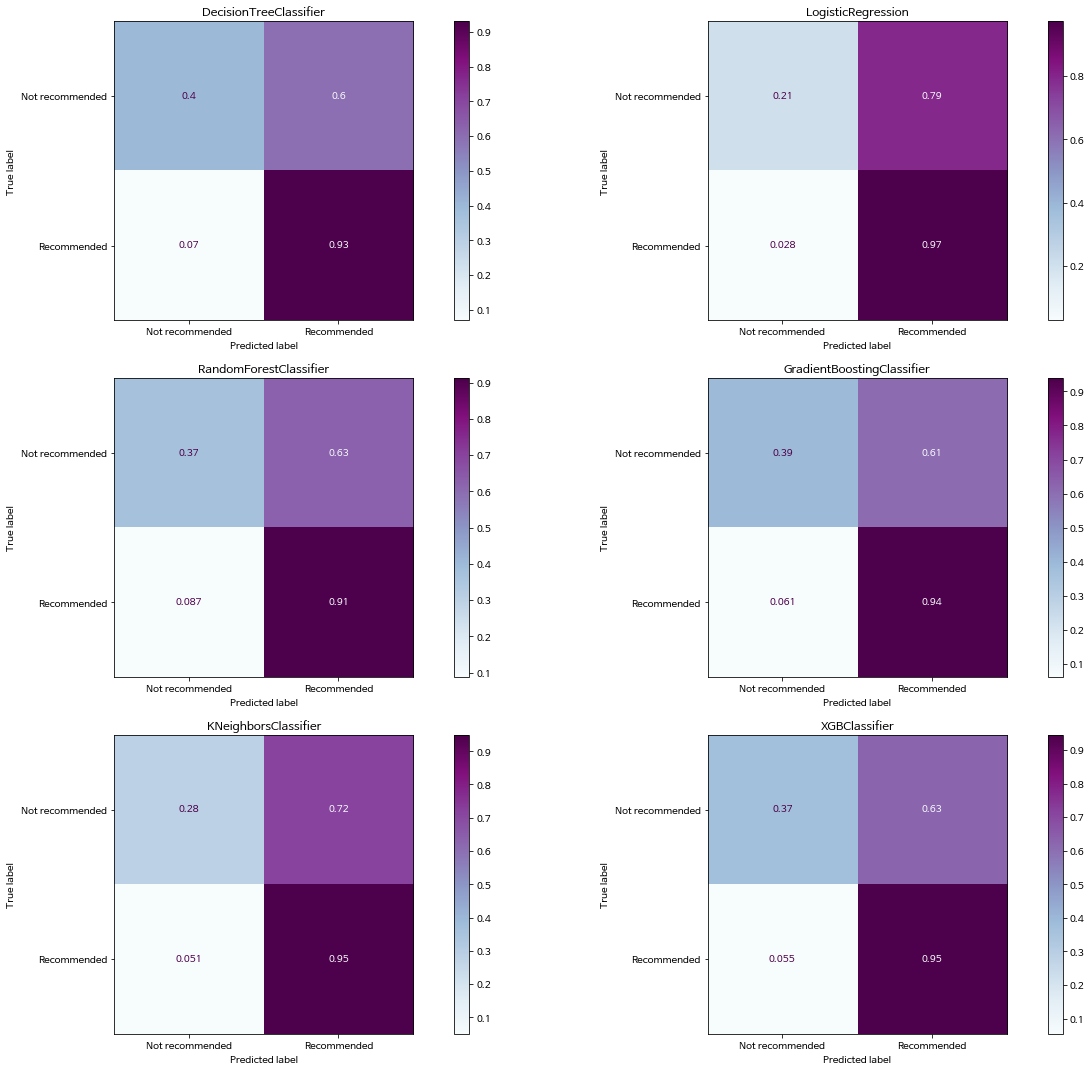

In [106]:
result_summary_list = runclassifiers(X_train_scaled, y_train, y_train_knn, X_test_scaled, y_test, y_test_knn)

##### Feature importance

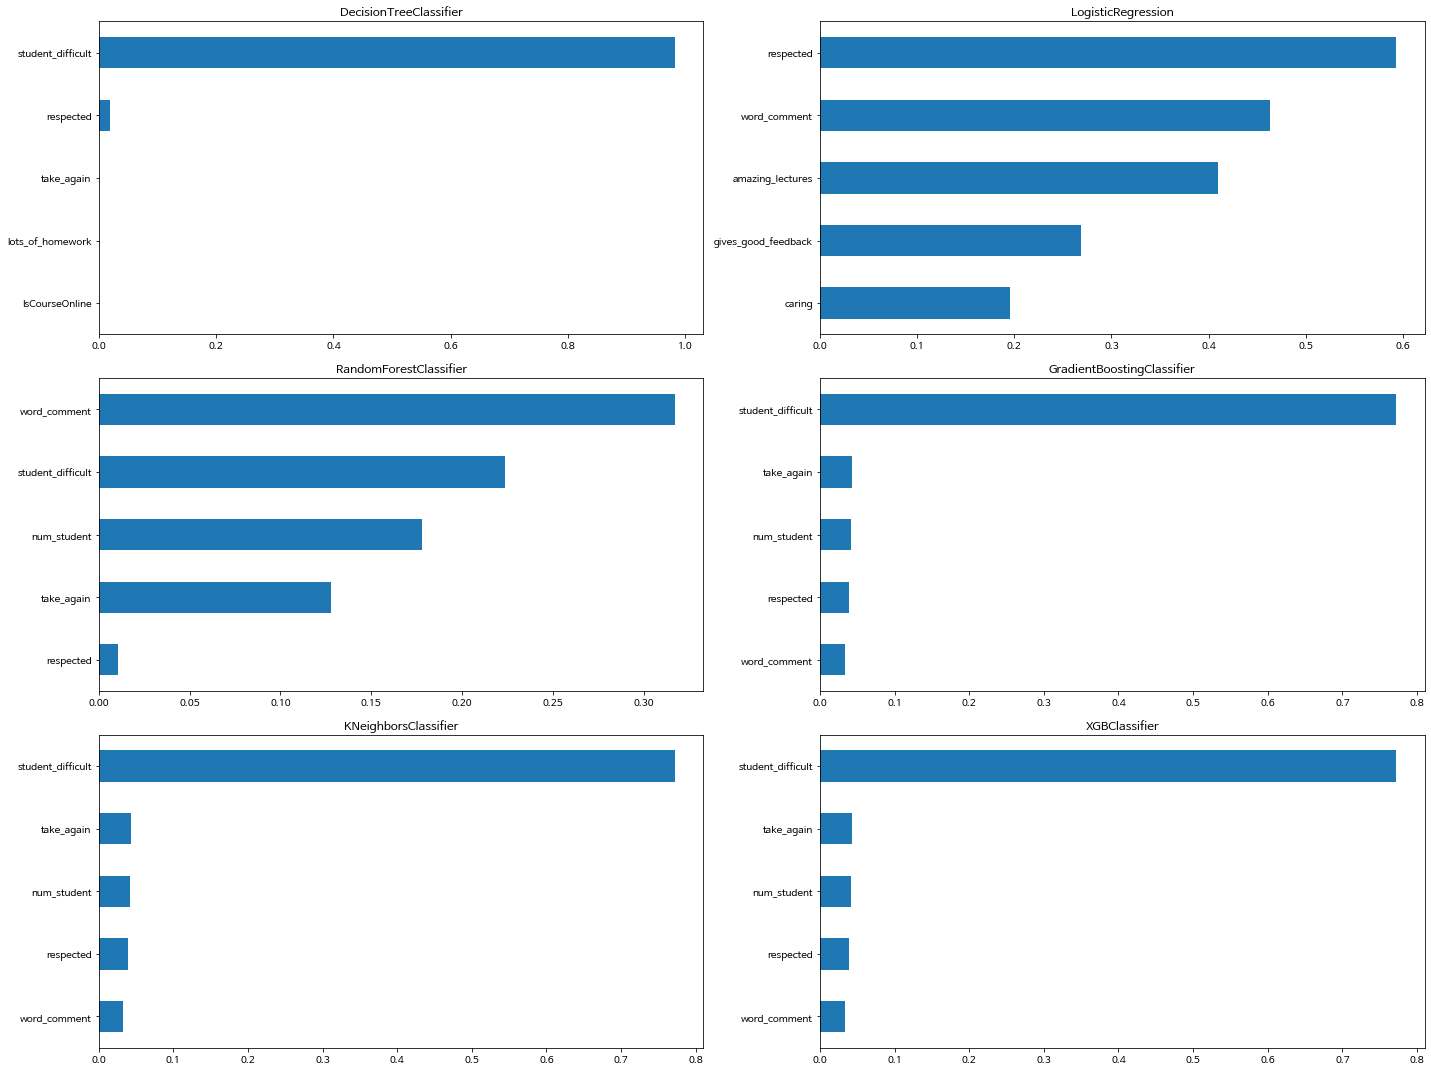

In [107]:
nm = result_summary_list.name.to_list()

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (20, 15))

for idx, imp_fea in enumerate(important_features_list):
    imp_fea.sort_values(ascending=False)[:5][::-1].plot(kind = 'barh', ax = ax[idx//2, idx%2])
    ax[idx//2, idx%2].set_title(nm[idx])
            
plt.tight_layout()
plt.show()

In [108]:
result_summary_list.sort_values(by=['Accuracy score','F-1 score'], ascending=[False,False])

,name,best_estimator,Precision,Recall,F-1 score,Accuracy score,Best score
5,XGBClassifier,XGBClassifier(n_estimators=250),0.824940,0.843465,0.828447,0.843465,0.843465
3,GradientBoostingClassifier,GradientBoostingClassifier(n_estimators=70),0.824896,0.841945,0.829242,0.841945,0.841945
0,DecisionTreeClassifier,DecisionTreeClassifier(max_depth=2),0.820193,0.836056,0.825309,0.836056,0.836056
1,LogisticRegression,LogisticRegression(),0.807992,0.835676,0.800523,0.835676,0.835676
4,KNeighborsClassifier,KNeighborsClassifier(n_neighbors=13),0.803980,0.830737,0.808006,0.830737,0.830737
2,RandomForestClassifier,RandomForestClassifier(),0.800947,0.816489,0.807098,0.816489,0.816489


`Feature importance`에서 모델들이 공통적으로 뽑은 중요한 Feature를 확인해 보겠습니다.

In [109]:
for i in range(6):
  print(nm[i])
  print('='*50)
  print(important_features_list[i].sort_values(ascending=False).head(3),'\n')

DecisionTreeClassifier
student_difficult    0.98131
respected            0.01869
take_again           0.00000
dtype: float64 

LogisticRegression
respected           0.592676
word_comment        0.463645
amazing_lectures    0.409925
dtype: float64 

RandomForestClassifier
word_comment         0.316941
student_difficult    0.223469
num_student          0.177842
dtype: float64 

GradientBoostingClassifier
student_difficult    0.771564
take_again           0.042661
num_student          0.041629
dtype: float64 

KNeighborsClassifier
student_difficult    0.771564
take_again           0.042661
num_student          0.041629
dtype: float64 

XGBClassifier
student_difficult    0.771564
take_again           0.042661
num_student          0.041629
dtype: float64 



공통으로 많이 뽑힌 feature는 

`student_difficult`

`word_comment`

`respected`, `num_student` 정도가 있습니다.

### 평가

두 라벨에 대한 분류를 모두 훌륭하게 해낸 모델이 존재하지 않습니다.

전체적으로 `Not recommended`를 `Recommended`로 잘못 예측해낸 케이스가 많습니다.

프로젝트 목표 상 주어진 데이터를 활용해 

해당 강좌 수강을 추천하는지, 추천하지 않는지 명확하게 구분해내야 하는데 라벨의 수가 적었던 `Not recommended`를 제대로 분류하지 못했습니다.

## **결론 및 후기**

다양한 `Classifier` 와 `GridSearchCV`를 통한 하이퍼 파라미터 튜닝으로 각 모델들을 학습해 보았습니다.

성능을 평가하자면 주어진 데이터를 활용해 2가지 라벨을 분류해내는 능력이 좋지는 않았습니다. 

-------------


하지만 각 모델별로 개별 특성들의 중요도를 얼만큼 여기는지 확인하고, 공통적으로 중요하다 여긴 피쳐를 알아냄으로써,

학생들이 **교수의 강좌를 평가**할 때 **어떤 부분을 가장 중요하게 여기는지** 알 수 있었습니다.






### **그렇다면 왜 성능이 좋지 못했을까요?**

제 견해를 말씀드리자면 모델 학습을 진행하기 전 제거한 feature 중 `comment`의 영향력이 다른 수치형 feature들 보다 더 컸을 거로 생각합니다.

1. 교수의 강좌 구성에는 시험의 양이 많다,
2. 교수의 강좌 구성이 훌륭하다.

이런 질문에 대해 `예 / 아니오`로 구성된 Feature보다, 학생이 직접 말로 풀어낸 데이터가 전달하는 `feature importance`가 더 많이 담겨 있을 거라는 가정을 남기겠습니다.

### **다음 목표**

이번 프로젝트에서 수치형 데이터들을 활용해 강좌 추천 여부를 분류하는 모델을 만들어봤다면,

다음 프로젝트 에서는 데이터속 `comment`를 활용해 강좌 추천 여부를 분류하는 프로젝트를 진행할 계획입니다.

감사합니다.